<a href="https://colab.research.google.com/github/darLloyd/Capsule-Network-Object-Detection/blob/main/Part_B_Conv_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Part B**

Here we seek to:


*   Evaluate the performance of a regular convolutional neural network, with respects to training accuracy and convergance speed, on the dataset.
*   Compare the results to that of our first Caps Net so as to evaluate which network design is most suited for this dataset.



In [ ]:
#imports required libraries
import numpy as np
import pandas as pd
import os
from random import shuffle
import random
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from tqdm import tqdm
import glob
from sklearn.cluster import DBSCAN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import datasets, layers, models

In [ ]:
# Allows colab to access loacl drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
 # loading required drive, timestamp and checkpoint parameters 

checkpoint_path = '/content/drive/MyDrive/'
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = './logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)
scalar_logdir = './logs/scalars/%s' % stamp
file_writer = tf.summary.create_file_writer(scalar_logdir + "/metrics")

In [ ]:
def checkpoint_path():
  checkpoint_path = '/content/drive/MyDrive/'


In [ ]:
# unzips and loads images

!unzip "/content/images.zip" -d "/content"


In [ ]:
path = "/content/images/*.*"



In [ ]:
# image augmentation function which also creates labeled data set

def image_and_labels(files):
  gray_images =[]
  one_hot_labels =[]
  labels = []
  
  for image in glob.glob(path):
    bee_image = cv2.imread(image,0) # reads image in grayscale
    bee_image = cv2.resize(bee_image, (200,200), interpolation=cv2.INTER_AREA ) #resizes image
    gray_images.append(bee_image)
    
    if "NP" in image:
      one_hot_labels.append(0) #creates one hot label
      labels.append("None Pollinating")
    else:
      one_hot_labels.append(1) #creates one hot label
      labels.append("Pollinating")

  return gray_images, one_hot_labels, labels

In [ ]:
# passes images from path to function 
X, y , y_label_names = image_and_labels(path)

In [ ]:
# applies shuffle to  both labels and image files

combine_files = list(zip(X, y))
random.shuffle(combine_files)

X, y = zip(*combine_files)


In [ ]:
labels = ["None Pollinating", 'Pollinating']

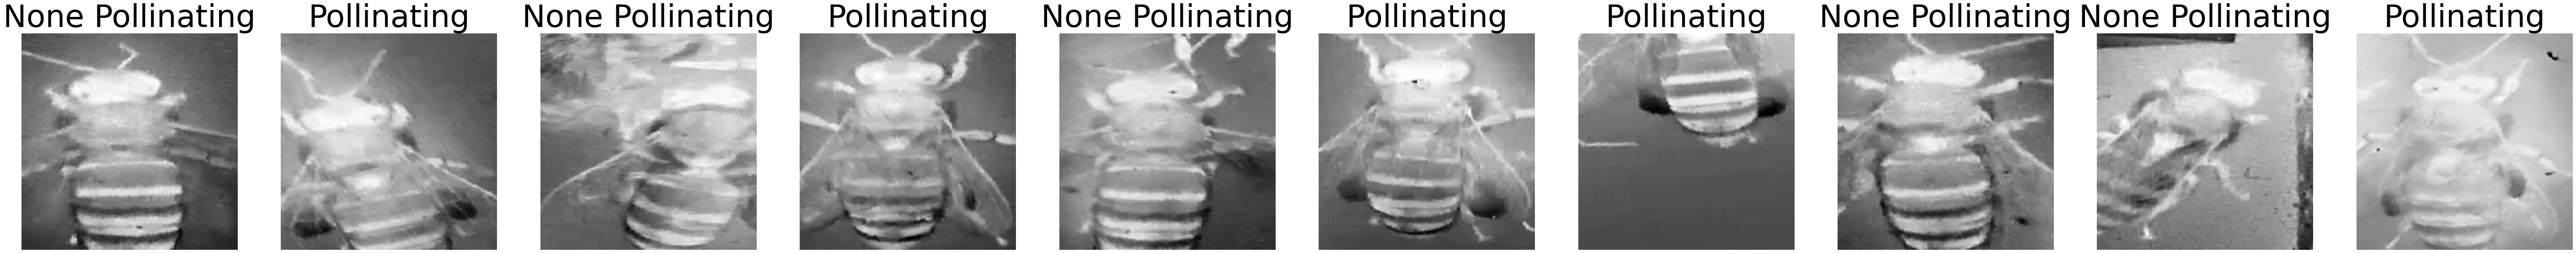

In [ ]:
# samples and dislayes image file after augmentation and labelling
test_samples = 10
test_labels = 10
sample_images = X[:test_samples]
sample_labels = y[:test_labels]


plt.figure(figsize=(test_samples * 10, 10))
for index in range(test_samples):
    plt.subplot(1, test_samples, index+1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title(labels[sample_labels[index]], fontdict={'fontsize': 68, 'fontweight': 'medium'})
    
    
    plt.axis("off")
plt.show()

In [ ]:
# converts image and labels to numpy arrays
X = np.array(X)
y = np.array(y)


In [ ]:
# reads size of array
print(X.shape)
print(y.shape)

(714, 200, 200)
(714,)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


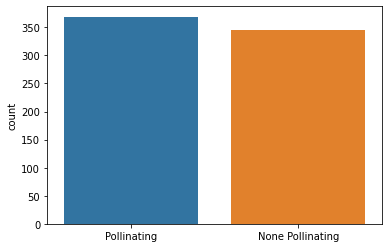

In [ ]:
plot_labels = sns.countplot(y_label_names)
plot_labels

In [ ]:
# imports and applies train-test-split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=4)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(571, 200, 200)
(143, 200, 200)
(571,)
(143,)


In [ ]:
#normalize images
X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
X_train = X_train.reshape(571,200,200,1)
X_test = X_test.reshape(143,200,200,1)

In [ ]:
y_train = y_train.reshape(571,-1)
y_test = y_test.reshape(143,-1)

In [ ]:
# creates function to apply further data augmentation 

def augment_using_ops(images, labels):
	images = tf.image.random_flip_left_right(images)
	images = tf.image.random_flip_up_down(images)
	images = tf.image.rot90(images)
	return (images, labels)

Here we apply tensorflow built in image augmentation methods. We will utilize:
- flipping the images from left to right
- flipping from up to down
- 90 degree rotations

In [ ]:
# applies augmentation to training and testing set

X_train, y_train = augment_using_ops(X_train, y_train)
X_test, y_test = augment_using_ops(X_test, y_test)

In [ ]:
# creates customized convolutional neural network

from gc import callbacks
def bee_model():
  model = tf.keras.Sequential([
                               tf.keras.layers.Conv2D(75, [3,3],strides=[1,1],padding="VALID", activation='relu', input_shape=(200,200,1)),
                               tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None),
                               #tf.keras.layers.Dropout(.3),
                               tf.keras.layers.Conv2D(128, [3,3],strides=[1,1],padding="VALID", activation='relu'),
                               tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None),
                               #tf.keras.layers.GlobalMaxPool2D(),
                               #tf.keras.layers.Dropout(.2),
                               tf.keras.layers.Conv2D(512, [3,3],strides=[1,1],padding="VALID", activation='relu'),
                               tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None),
                               #tf.keras.layers.Dropout(.3),
                               tf.keras.layers.Conv2D(1024, [2,2],strides=[1,1],padding="VALID", activation='relu'),
                               tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None),
                               #tf.keras.layers.Dropout(.2),

                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(1024, activation='relu'),
                               #tf.keras.layers.Dropout(.2),
                               
                               tf.keras.layers.Dense(1024, activation='relu'),
                               #tf.keras.layers.Dropout(.1),
                               
                               tf.keras.layers.Dense(1, activation='sigmoid'),
                               #tf.keras.layers.Dense(1)
                               

                            
                            ])
  
  checkpoint_path_ = checkpoint_path()
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(                      
      filepath = checkpoint_path_,
      save_weights_only = False,
      monitor ="Loss",
      mode = 'min',
      save_best_only = True
                        )

  callbacks = [
              EarlyStopping(patience=7),
              model_checkpoint_callback
                        ]
  return model, callbacks
model, callbacks = bee_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 75)      750       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 128)       86528     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 512)       590336    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 512)      0

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(
  X_train,
  y_train,
  epochs=150,
  validation_data=(X_test, y_test),
  callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

Epoch 1/150
18/18 [==============================] - 15s 218ms/step - loss: 0.6933 - accuracy: 0.4974 - val_loss: 0.6916 - val_accuracy: 0.5664
Epoch 2/150
18/18 [==============================] - 2s 123ms/step - loss: 0.6913 - accuracy: 0.5131 - val_loss: 0.6888 - val_accuracy: 0.5455
Epoch 3/150
18/18 [==============================] - 2s 123ms/step - loss: 0.6896 - accuracy: 0.5306 - val_loss: 0.6876 - val_accuracy: 0.5524
Epoch 4/150
18/18 [==============================] - 2s 124ms/step - loss: 0.6852 - accuracy: 0.5184 - val_loss: 0.6851 - val_accuracy: 0.5385
Epoch 5/150
18/18 [==============================] - 2s 123ms/step - loss: 0.6801 - accuracy: 0.5604 - val_loss: 0.6781 - val_accuracy: 0.6294
Epoch 6/150
18/18 [==============================] - 2s 123ms/step - loss: 0.6722 - accuracy: 0.5744 - val_loss: 0.6699 - val_accuracy: 0.6224
Epoch 7/150
18/18 [==============================] - 2s 123ms/step - loss: 0.6570 - accuracy: 0.6147 - val_loss: 0.6571 - val_accuracy: 0.622

In [ ]:
model.evaluate(X_test,  y_test, verbose=2)

5/5 - 0s - loss: 0.3225 - accuracy: 0.8531 - 187ms/epoch - 37ms/step


[0.32246431708335876, 0.8531468510627747]

85% Test accuracy after 65 epochs ✌

In [ ]:
predictions = np.squeeze(model.predict(X_test) >= 0.5).astype(int)

In [ ]:
y_pred = predictions

In [ ]:
# reshapes y labels to a 1D array

y_test2 =y_test.reshape(-1)
y_test2.shape

(143,)

In [ ]:
# Lets have a look at the confusion matrix

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)
y_actux = pd.Series(y_test2, name='Actual')
y_predx = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actux, y_predx)
df_confusion1 = pd.crosstab(y_actux, y_predx, rownames=['Actual'], colnames=['Predicted'], margins=False)
df_confusion1

Predicted,0,1
Actual,,
0,55,10
1,11,67



From the one-hot encoding, 0 represented non pollinating bees and 1 represented pollinating bees.

Based on this result we can see that the model was able to accurately predict each label roughly 85% of the time.